In [23]:
# from fastai import *
# from fastbook import *
from fastai.vision.all import *
import os
import gdown

# Entega 1

## Download Dataset

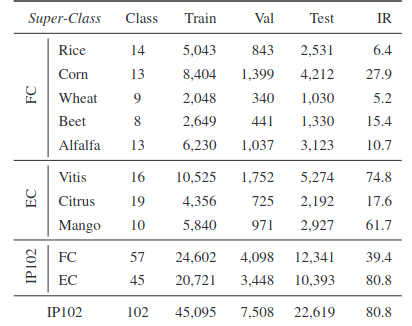

Abaixo as constantes para o caminho dos arquivos do dataset.

In [2]:
WORKDIR = Path('.')
DATASET_ROOT = Path('ip102_v1.1')
CLASSES_FILE = Path('classes.txt')
TARFILE_PATH = Path('ip102_v1.1.tar')
TEST_FILE = DATASET_ROOT/'test.txt'
TRAIN_FILE = DATASET_ROOT/'train.txt'
VAL_FILE = DATASET_ROOT/'val.txt'
IMAGES_PATH = DATASET_ROOT/'images'

In [3]:
files = [('1Xa3p1h8jkk7ECHzSuGYrn-d39QOd0ezj', f'{CLASSES_FILE}'),
         ('1EL9TA-J5XsiBR4M3nQkMR_e-2dP48eQN', f'{TARFILE_PATH}')]
[gdown.download(id=id, output=fname, quiet=True) for id, fname in files]

['classes.txt', 'ip102_v1.1.tar']

Os arquivos do dataset são baixados de uma pasta compartilhada no google drive. O `gdown` serve para baixar estes arquivos.

A lista `files` recebe tuplas, cujo primeiro elemento é o id único do link dos arquivos no drive e o segundo elemento é o nome do arquivo

In [4]:
untar_dir(TARFILE_PATH, WORKDIR)

## Files Reading

In [3]:
# reads the classes.txt file and returns a list of tuple(id, class_name)
def classes_set():
  with open(CLASSES_FILE, 'r') as fd:
    classes = map(lambda line: line.split(maxsplit=1), fd)
    classes = map(lambda pair: (int(pair[0])-1, pair[1].strip()), classes)
    classes = list(classes)
  return classes

A função `classes_set` faz a separação entre os ids e nomes das classes, e a `get_label_file_data` separa o nome das imagens e seus repespectivos ids.

In [4]:
# reads the file appointed in path FILE and returns a list of tuple(image_name, id)
def get_label_file_data(FILE):
  with open(FILE, 'r') as fd:
    data = map(lambda line: line.split(), fd)
    data = map(lambda pair: (pair[0], int(pair[1].replace('\n', ''))), data)
    data = list(data)
  return data

O pandas é usado para unir as listas das classes com as listas dos arquivos de treino, validação e teste.

In [5]:
classes = classes_set()
df_classes = pd.DataFrame(data={
    'id': [i[0] for i in classes],
    'label': [i[1] for i in classes]
})

In [6]:
train_pairs = get_label_file_data(TRAIN_FILE)
df_train = pd.DataFrame(data={
    'image': [i[0] for i in train_pairs],
    'id': [i[1] for i in train_pairs],
    'is_valid': 0
})

In [7]:
val_pairs = get_label_file_data(VAL_FILE)
df_val = pd.DataFrame(data={
    'image': [i[0] for i in val_pairs],
    'id': [i[1] for i in val_pairs],
    'is_valid': 1
})

In [8]:
df_classes

,id,label
0,0,rice leaf roller
1,1,rice leaf caterpillar
2,2,paddy stem maggot
3,3,asiatic rice borer
4,4,yellow rice borer
...,...,...
97,97,Chlumetia transversa
98,98,Mango flat beak leafhopper
99,99,Rhytidodera bowrinii white
100,100,Sternochetus frigidus


In [9]:
df_train

,image,id,is_valid
0,00002.jpg,0,0
1,00003.jpg,0,0
2,00005.jpg,0,0
3,00006.jpg,0,0
4,00008.jpg,0,0
...,...,...,...
45090,75212.jpg,101,0
45091,75214.jpg,101,0
45092,75216.jpg,101,0
45093,75217.jpg,101,0


In [10]:
df_val

,image,id,is_valid
0,00009.jpg,0,1
1,00012.jpg,0,1
2,00014.jpg,0,1
3,00034.jpg,0,1
4,00035.jpg,0,1
...,...,...,...
7503,75187.jpg,101,1
7504,75191.jpg,101,1
7505,75202.jpg,101,1
7506,75206.jpg,101,1


A função `pd.concat` concatena os dataframes de treinamento e de validação em um único dataframe.

In [11]:
df = pd.concat((df_train, df_val))

In [12]:
df

,image,id,is_valid
0,00002.jpg,0,0
1,00003.jpg,0,0
2,00005.jpg,0,0
3,00006.jpg,0,0
4,00008.jpg,0,0
...,...,...,...
7503,75187.jpg,101,1
7504,75191.jpg,101,1
7505,75202.jpg,101,1
7506,75206.jpg,101,1


A função `merge` faz a junção entre os dataframes de classes e treino/validação a partir do id.

In [13]:
df = df_classes.merge(df, how='inner', on='id')

In [14]:
df

,id,label,image,is_valid
0,0,rice leaf roller,00002.jpg,0
1,0,rice leaf roller,00003.jpg,0
2,0,rice leaf roller,00005.jpg,0
3,0,rice leaf roller,00006.jpg,0
4,0,rice leaf roller,00008.jpg,0
...,...,...,...,...
52598,101,Cicadellidae,75187.jpg,1
52599,101,Cicadellidae,75191.jpg,1
52600,101,Cicadellidae,75202.jpg,1
52601,101,Cicadellidae,75206.jpg,1


In [15]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader('image', pref=IMAGES_PATH),
                   get_y=ColReader('label'),
                   item_tfms=Resize(224))

In [16]:
dl = dblock.dataloaders(df)

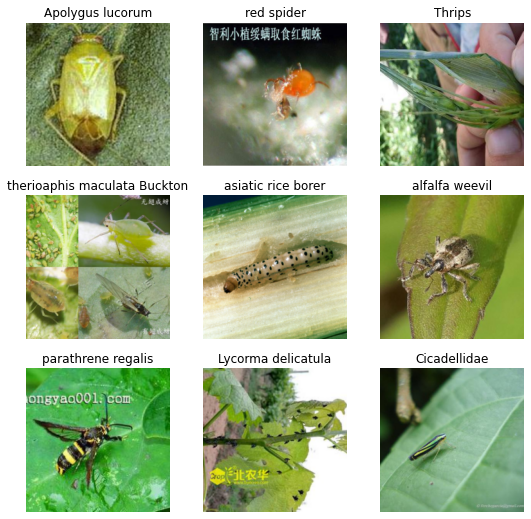

In [17]:
dl.show_batch()

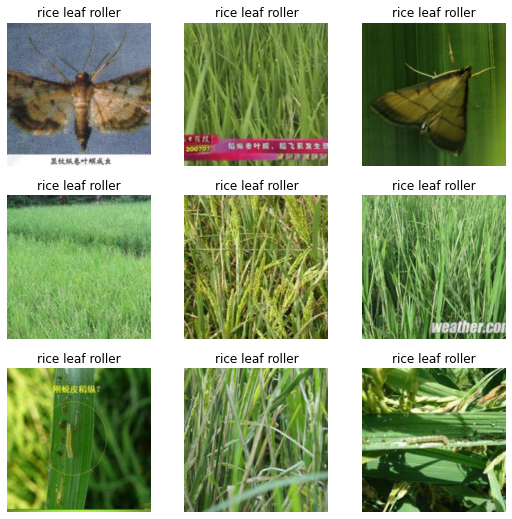

In [18]:
dl.valid.show_batch()

# Entrega 2

## Fine tuning

In [ ]:
prec = Precision(average='weighted')
rec = Recall(average='weighted')
auc = RocAuc(average='weighted')

learn = vision_learner(dl, arch=alexnet, metrics=[prec, rec, auc, error_rate], opt_func=SGD, lr=0.01, wd=0.0005)
learn.fine_tune(40)

## Interpreter

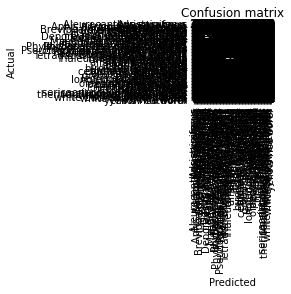

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


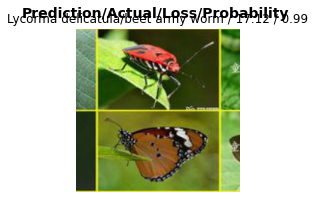

In [ ]:
interp.plot_top_losses(1, nrows=1)

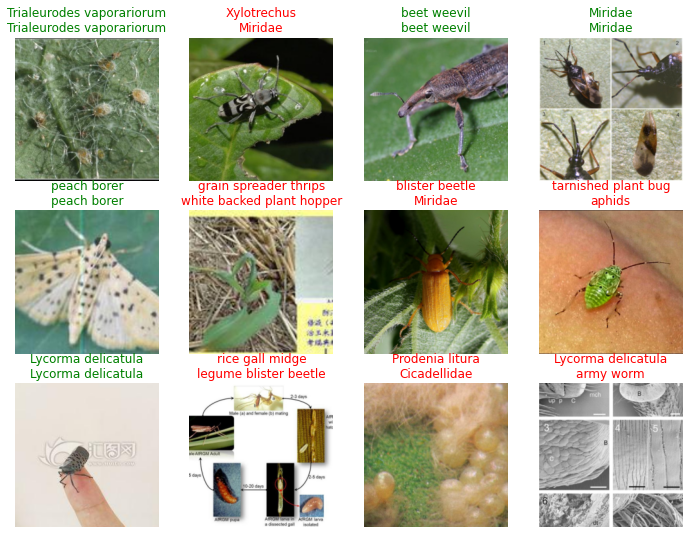

In [ ]:
learn.show_results(max_n=12)

## Export

In [ ]:
learn.export()

## Import

In [ ]:
learn = load_learner('./export.pkl')

## Perguntas

1. Qual a arquitetura geral?
1. Quais as ativações de cada bloco?
1. Quais a dimensões de input/output?
1. Quais são? Como foram definidos?
1. Qual o efeito de cada um na rede?
1. Qual a métrica de sucesso?
1. Como ela é calculada?
1. Como ela opera na função de loss?